## 🧐<u> Understanding/defining business problem <u>
Understand how products are doing in the market. How are customers 
reacting to a particular product? What is the consumer’s sentiment 
across products? Many more questions like these can be answered using 
sentiment analysis.

## Identifying potential data sources, collection, and understanding

  # <u>Amazon Fine Food Reviews Analysis<u>
         

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.                                                                                                  

  - Number of reviews: 568,454
  - Number of users: 256,059
  - Number of products: 74,258
  - Timespan: Oct 1999 - Oct 2012
  - Number of Attributes/Columns in data: 10

  
    **Attribute Information**:

  - Id
  - ProductId - unique identifier for the product
  - UserId - unqiue identifier for the user
  - ProfileName
  - HelpfulnessNumerator - number of users who found the review helpful
  - HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
  - Score - rating between 1 and 5
  - Time - timestamp for the review
  - Summary - brief summary of the review
  - Text - text of the review
  
**Objective**:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).
    
    
 ![amazon]( https://m.media-amazon.com/images/G/31/img18/Fresh/image_24.png)

In [1]:
# Import necessary libraries
import numpy as np
import pandas as pd
import os
import re
from nltk import word_tokenize
import gensim
from collections import Counter
from nltk.stem import WordNetLemmatizer
import matplotlib.colors as mcolors
from gensim.models import word2vec
import nltk
import json

In [2]:
#Read the data
df = pd.read_csv('Reviews.csv')

In [3]:
#look at the top 5 rows of the data
df.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...


In [4]:
#uderstand the data types of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 568454 entries, 0 to 568453
Data columns (total 10 columns):
 #   Column                  Non-Null Count   Dtype 
---  ------                  --------------   ----- 
 0   Id                      568454 non-null  int64 
 1   ProductId               568454 non-null  object
 2   UserId                  568454 non-null  object
 3   ProfileName             568438 non-null  object
 4   HelpfulnessNumerator    568454 non-null  int64 
 5   HelpfulnessDenominator  568454 non-null  int64 
 6   Score                   568454 non-null  int64 
 7   Time                    568454 non-null  int64 
 8   Summary                 568427 non-null  object
 9   Text                    568454 non-null  object
dtypes: int64(5), object(5)
memory usage: 43.4+ MB


In [5]:
df.columns

Index(['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator',
       'HelpfulnessDenominator', 'Score', 'Time', 'Summary', 'Text'],
      dtype='object')

In [6]:
# list of numerical variables............
numerical_features = [feature for feature in df.columns if df[feature].dtypes != 'O']
print('Number of numerical variables: ', len(numerical_features))
print('-'*80)
print('Numerical Variables Column: ',numerical_features)

Number of numerical variables:  5
--------------------------------------------------------------------------------
Numerical Variables Column:  ['Id', 'HelpfulnessNumerator', 'HelpfulnessDenominator', 'Score', 'Time']


In [7]:
# list of categorical variables............
cat_features = [feature for feature in df.columns if df[feature].dtypes == 'O']
print('Number of Categorical variables: ', len(cat_features))
print('-'*80)
print('Categorical Variables Column: ',cat_features)

Number of Categorical variables:  5
--------------------------------------------------------------------------------
Categorical Variables Column:  ['ProductId', 'UserId', 'ProfileName', 'Summary', 'Text']


In [8]:
#Top 10 HelpfulnessNumerator.....
vc = df['HelpfulnessNumerator'].value_counts().to_frame().reset_index().head(10)
vc

,index,HelpfulnessNumerator
0,0,303826
1,1,116467
2,2,53727
3,3,29007
4,4,16963
5,5,11462
6,6,7387
7,7,5402
8,8,3887
9,9,3082


In [9]:
#Top 10 HelpfulnessDenominator.....
vc = df['HelpfulnessDenominator'].value_counts().to_frame().reset_index().head(10)
vc

,index,HelpfulnessDenominator
0,0,270052
1,1,112753
2,2,61482
3,3,34394
4,4,22306
5,5,14824
6,6,10378
7,7,7461
8,8,5416
9,9,4406


In [10]:
# Statistics on Numerical data......
round(df.describe(exclude = ['object']), 2).T.style.background_gradient(cmap='YlGn')

,count,mean,std,min,25%,50%,75%,max
Id,568454.000000,284227.500000,164098.680000,1.000000,142114.250000,284227.500000,426340.750000,568454.000000
HelpfulnessNumerator,568454.000000,1.740000,7.640000,0.000000,0.000000,0.000000,2.000000,866.000000
HelpfulnessDenominator,568454.000000,2.230000,8.290000,0.000000,0.000000,1.000000,2.000000,923.000000
Score,568454.000000,4.180000,1.310000,1.000000,4.000000,5.000000,5.000000,5.000000
Time,568454.000000,1296256604.900000,48043312.330000,939340800.000000,1271289600.000000,1311120000.000000,1332720000.000000,1351209600.000000


In [11]:
#Looking at the summary of the reviews
df.Summary.head(5)

0    Good Quality Dog Food
1        Not as Advertised
2    "Delight" says it all
3           Cough Medicine
4              Great taffy
Name: Summary, dtype: object

In [12]:
#lookin at the description of the reviews
df.Text.head(5)

0    I have bought several of the Vitality canned d...
1    Product arrived labeled as Jumbo Salted Peanut...
2    This is a confection that has been around a fe...
3    If you are looking for the secret ingredient i...
4    Great taffy at a great price.  There was a wid...
Name: Text, dtype: object

In [13]:
df = pd.DataFrame(df, columns=['Id', 'ProductId', 'UserId', 'ProfileName', 'HelpfulnessNumerator','HelpfulnessDenominator', 'Score', 'Summary','Text','Time'])

print(df.shape)
df.head()

(568454, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Summary,Text,Time
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,Good Quality Dog Food,I have bought several of the Vitality canned d...,1303862400
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,1346976000
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,"""Delight"" says it all",This is a confection that has been around a fe...,1219017600
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,Cough Medicine,If you are looking for the secret ingredient i...,1307923200
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,Great taffy,Great taffy at a great price. There was a wid...,1350777600


In [14]:
df['Score'].astype('category').value_counts()

5    363122
4     80655
1     52268
3     42640
2     29769
Name: Score, dtype: int64

In [15]:
df.corr()

C:\Users\Dattesh\AppData\Local\Temp\ipykernel_10172\1134722465.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  df.corr()


,Id,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time
Id,1.000000,0.001227,0.000770,0.010706,0.007912
HelpfulnessNumerator,0.001227,1.000000,0.974689,-0.032590,-0.154818
HelpfulnessDenominator,0.000770,0.974689,1.000000,-0.097986,-0.173289
Score,0.010706,-0.032590,-0.097986,1.000000,-0.062760
Time,0.007912,-0.154818,-0.173289,-0.062760,1.000000


C:\Users\Dattesh\AppData\Local\Temp\ipykernel_10172\129235704.py:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = df.corr()


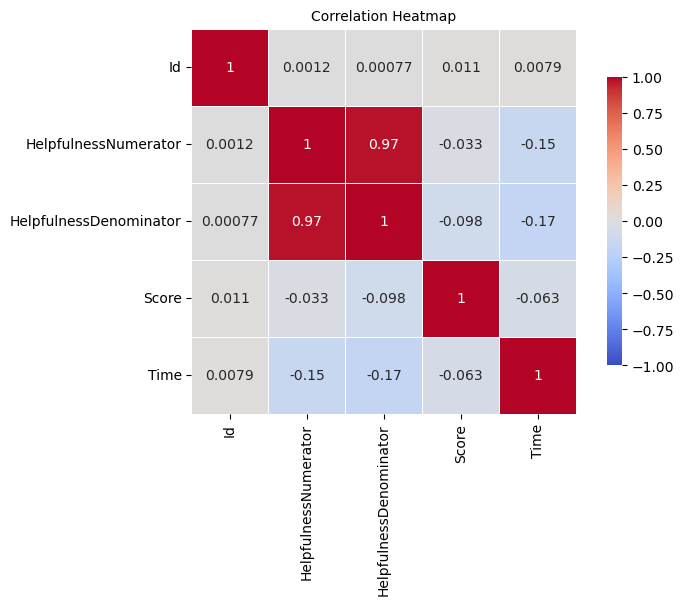

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt
# Calculate the correlation matrix
corr_matrix = df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(8, 5))

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0, 
            square=True, linewidths=.5, cbar_kws={"shrink": .75})

# Set the title of the plot
plt.title('Correlation Heatmap', size=10)

# Show the plot
plt.show()

## Exploratory data analysis

This step is not connected anywhere in predicting sentiments; what we are
trying to do here is to dig deeper into the data and understand it.

# <u>Data Cleaning<u>

#### **Handling Missing Data**:

In [17]:
#Check for Missing Values
df.isnull().sum()

Id                         0
ProductId                  0
UserId                     0
ProfileName               16
HelpfulnessNumerator       0
HelpfulnessDenominator     0
Score                      0
Summary                   27
Text                       0
Time                       0
dtype: int64

In [18]:
df['ProfileName'].fillna('Unknown', inplace=True)

#### Convert Data Types:

In [19]:
#Convert Time to DateTime:
df['Time'] = pd.to_datetime(df['Time'], unit='s')  # Assuming Time is in Unix timestamp

#### Outlier Detection:

<Axes: >

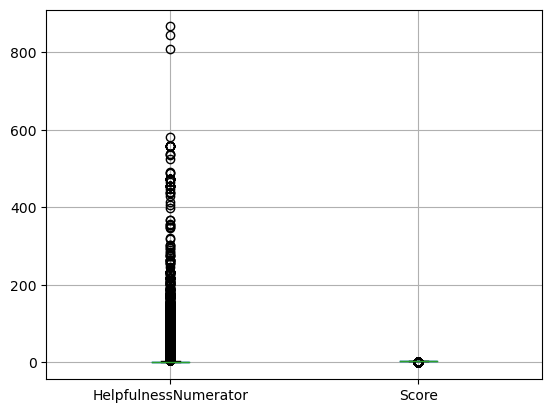

In [20]:
#Visualize Outliers:
df[['HelpfulnessNumerator','Score']].boxplot()

In [21]:
#Cap Outliers
df['HelpfulnessNumerator'] = np.clip(df['HelpfulnessNumerator'], 0, df['HelpfulnessNumerator'].quantile(0.99))

In [22]:
for i in df.columns:
    print("Missing Values in ",i," is -", df[i].isna().sum())

Missing Values in  Id  is - 0
Missing Values in  ProductId  is - 0
Missing Values in  UserId  is - 0
Missing Values in  ProfileName  is - 0
Missing Values in  HelpfulnessNumerator  is - 0
Missing Values in  HelpfulnessDenominator  is - 0
Missing Values in  Score  is - 0
Missing Values in  Summary  is - 27
Missing Values in  Text  is - 0
Missing Values in  Time  is - 0


#### Handling Duplicates:

In [23]:
df.duplicated(subset={"UserId","ProfileName","Time","Text"}).value_counts() # checking duplicates

False    393933
True     174521
dtype: int64

In [24]:
#Sorting data according to ProductId in ascending order
sorted_data=df.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [25]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(393933, 10)

#### Helpfullness Numerator Greater than Helpfullness Denominator
- HelpfulnessNumerator = (Yes) Review is good or not
- HelpfulnessDenominator = (Yes + No) Review is good or not

In [26]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(df['Id'].size*1.0)*100

69.29901100176971

In [27]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [28]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(393931, 10)


5    250966
4     56086
1     36307
3     29772
2     20800
Name: Score, dtype: int64

In [29]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [30]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()


(393931, 10)


5    250966
4     56086
1     36307
3     29772
2     20800
Name: Score, dtype: int64

## <u>Text Preprocessing<u>

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the url tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords

After which we collect the words used to describe positive and negative reviews

In [31]:
#Import libraries
from nltk.corpus import stopwords
from textblob import TextBlob
from textblob import Word

In [32]:
example = df['Text'][11]
print(example)

One of my boys needed to lose some weight and the other didn't.  I put this food on the floor for the chubby guy, and the protein-rich, no by-product food up higher where only my skinny boy can jump.  The higher food sits going stale.  They both really go for this food.  And my chubby boy has been losing about an ounce a week.


#### Tokenizing Text

*Tokenization refers to splitting text into minimal meaningful units. There is a sentence tokenizer and word tokenizer.* 

In [33]:
tokens = nltk.word_tokenize(example)
tokens[:5]

['One', 'of', 'my', 'boys', 'needed']

 #### Removing Stop Words

*Stop words are very common words that carry no meaning or less meaning compared to other keywords. If we remove the words that are less commonly used, we can focus on the important keywords instead.*

In [34]:
#Removel of stop words
stop = stopwords.words('english')
df['Text'] = df['Text'].apply(lambda x:"".join(x for x in x.split() if x not in stop))
df.Text.head(5)

0    IboughtseveralVitalitycanneddogfoodproductsfou...
1    ProductarrivedlabeledJumboSaltedPeanuts...thep...
2    Thisconfectionaroundcenturies.Itlight,pillowyc...
3    IflookingsecretingredientRobitussinIbelieveIfo...
4    Greattaffygreatprice.Therewideassortmentyummyt...
Name: Text, dtype: object

#### Converting Text Data to Lowercase:

In [35]:
#Converting uppercase into lowercase
df['Text'] = df['Text'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df.Text.head(5)

0    iboughtseveralvitalitycanneddogfoodproductsfou...
1    productarrivedlabeledjumbosaltedpeanuts...thep...
2    thisconfectionaroundcenturies.itlight,pillowyc...
3    iflookingsecretingredientrobitussinibelieveifo...
4    greattaffygreatprice.therewideassortmentyummyt...
Name: Text, dtype: object

 #### Removing Punctuation

*This step is very important as punctuation doesn’t add any extra information or value. Hence removal of all such instances will help reduce the size of the data and increase computational efficiency*

In [36]:
import string
PUNCT_TO_REMOVE = string.punctuation
def remove_punctuation(text):
    """custom function to remove the punctuation"""
    return text.translate(str.maketrans('', '', PUNCT_TO_REMOVE))

df['Text'] = df['Text'].apply(lambda text: remove_punctuation(text))   
df.Text.head()

0    iboughtseveralvitalitycanneddogfoodproductsfou...
1    productarrivedlabeledjumbosaltedpeanutsthepean...
2    thisconfectionaroundcenturiesitlightpillowycit...
3    iflookingsecretingredientrobitussinibelieveifo...
4    greattaffygreatpricetherewideassortmentyummyta...
Name: Text, dtype: object

#### Removal of urls

*URLs (or Uniform Resource Locators) in a text are references to a location on the web, but do not provide any additional information. We thus, remove these too using the library named re, which provides regular expression matching operations.*

In [37]:
## Removal of urls
def remove_urls(text):
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

df['Text'] = df['Text'].apply(lambda text: remove_urls(text))
df.Text.head()

0    iboughtseveralvitalitycanneddogfoodproductsfou...
1    productarrivedlabeledjumbosaltedpeanutsthepean...
2    thisconfectionaroundcenturiesitlightpillowycit...
3    iflookingsecretingredientrobitussinibelieveifo...
4    greattaffygreatpricetherewideassortmentyummyta...
Name: Text, dtype: object

In [38]:
import matplotlib.pyplot as plt
#Create a new data frame "reviews" to perform exploratory data analysis upon that
reviews =df
#Dropping null values
reviews.dropna(inplace=True)

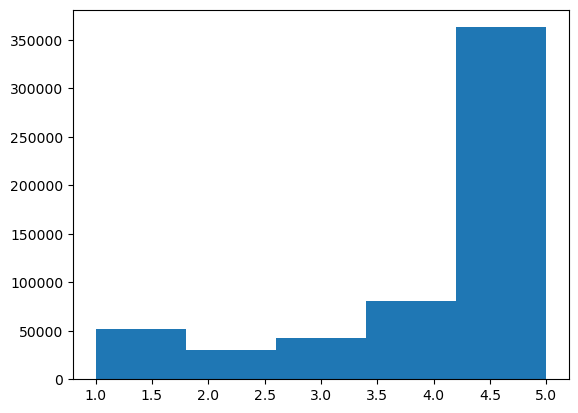

Score
1     52268
2     29744
3     42638
4     80655
5    363122
Name: Text, dtype: int64


In [39]:
#The histogram reveals this dataset is highly unbalanced towards hih rating 
reviews.Score.hist(bins=5,grid=False)
plt.show()
print(reviews.groupby('Score').count().Text)

In [40]:
# Sample size for each score category
sample_size = 29743

# Ensure sample size does not exceed available rows
score_1 = reviews[reviews['Score'] == 1].sample(n=min(sample_size, len(reviews[reviews['Score'] == 1])), random_state=42)
score_2 = reviews[reviews['Score'] == 2].sample(n=min(sample_size, len(reviews[reviews['Score'] == 2])), random_state=42)
score_3 = reviews[reviews['Score'] == 3].sample(n=min(sample_size, len(reviews[reviews['Score'] == 3])), random_state=42)
score_4 = reviews[reviews['Score'] == 4].sample(n=min(sample_size, len(reviews[reviews['Score'] == 4])), random_state=42)
score_5 = reviews[reviews['Score'] == 5].sample(n=min(sample_size, len(reviews[reviews['Score'] == 5])), random_state=42)

# Combine the sampled DataFrames
balanced_reviews = pd.concat([score_1, score_2, score_3, score_4, score_5])

# Check the balanced result
print("Balanced Reviews Score Distribution:")
print(balanced_reviews['Score'].value_counts())


Balanced Reviews Score Distribution:
1    29743
2    29743
3    29743
4    29743
5    29743
Name: Score, dtype: int64


In [41]:
#Here we recreate a 'balanced' dataset.
reviews_sample = pd.concat([score_1,score_2,score_3,score_4,score_5],axis =0)
reviews_sample.reset_index(drop=True,inplace=True)
#Printing count by 'Score' to check dataset is now balanced.
print(reviews_sample.groupby('Score').count().Text)

Score
1    29743
2    29743
3    29743
4    29743
5    29743
Name: Text, dtype: int64


#### Build Wordcloud

*Wordcloud is the pictorial representation of the most frequently repeated words representing the size of the word.*

In [42]:
#Let's build a word cloud looking at the 'Summary' text
from  wordcloud import WordCloud
from wordcloud import STOPWORDS

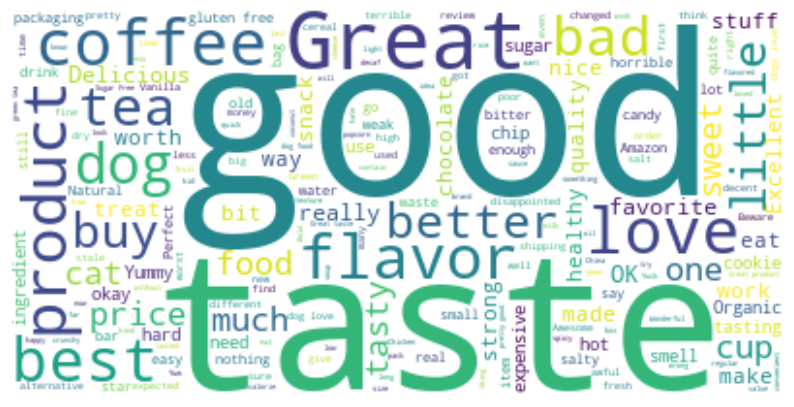

In [43]:
#Wordcloud function;s input needs to be a single string of text.
#Here I'm concatenating all Summaries into a single string.
#similarly you can bulid for Text column
reviews_str = reviews_sample.Summary.str.cat()
wordcloud = WordCloud(background_color='white').generate(reviews_str)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud,interpolation='bilinear')
plt.axis("off")
plt.show()

In [44]:
#Now let's split the data into Negative(Score is 1 or 2) and Positive(4 or#5) Reviews.
negative_reviews = reviews_sample[reviews_sample['Score'].isin([1,2])]
positive_reviews = reviews_sample[reviews_sample['Score'].isin([4,5])]

In [45]:
# Check the distribution of scores in each category
print("Negative Reviews Score Distribution:")
print(negative_reviews['Score'].value_counts())

print("\nPositive Reviews Score Distribution:")
print(positive_reviews['Score'].value_counts())


Negative Reviews Score Distribution:
1    29743
2    29743
Name: Score, dtype: int64

Positive Reviews Score Distribution:
4    29743
5    29743
Name: Score, dtype: int64


In [46]:
#Transform to sinle string
negative_reviews_str = negative_reviews.Summary.str.cat()
positive_reviews_str = positive_reviews.Summary.str.cat()
#Create wordclouds
wordcloud_negative = WordCloud(background_color ='white').generate(negative_reviews_str)
wordcloud_positive = WordCloud(background_color='white').generate(positive_reviews_str)

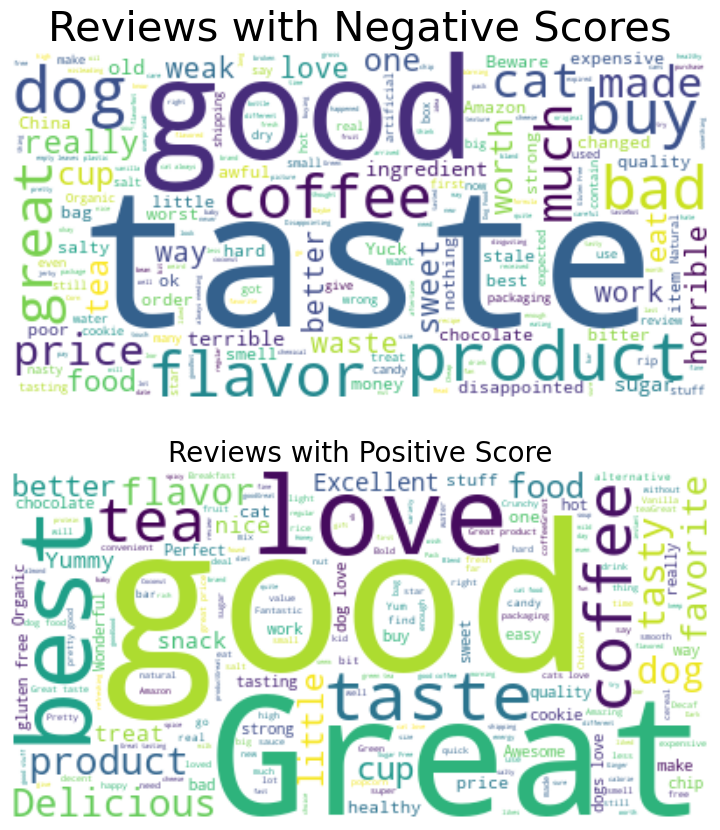

In [47]:
#plot
fig =plt.figure(figsize=(10,10))
ax1 =fig.add_subplot(211)
ax1.imshow(wordcloud_negative,interpolation='bilinear')
ax1.axis("off")
ax1.set_title('Reviews with Negative Scores',fontsize=30)

ax2 = fig.add_subplot(212)
ax2.imshow(wordcloud_positive,interpolation ='bilinear')
ax2.axis("off")
ax2.set_title('Reviews with Positive Score', fontsize=20)
plt.show()

In [48]:
dummies = pd.get_dummies(df['Score'])
dummies.head()

,1,2,3,4,5
0,0,0,0,0,1
1,1,0,0,0,0
2,0,0,0,1,0
3,0,1,0,0,0
4,0,0,0,0,1


### Splitting the data

In [49]:
#Generating train and test sets
from sklearn.model_selection import train_test_split
train_x, valid_x, train_y, valid_y = train_test_split(df.Text,df.Score,random_state = 0)
print(train_x.shape)
print(valid_x.shape)
print(train_y.shape)
print(valid_y.shape)

(426320,)
(142107,)
(426320,)
(142107,)


## Feature engineering

Review text, preprocessed one converted into vectors using (TFIDF)

### Converting Text to Features Using TF-IDF
#### Term frequency (TF):
Term frequency is simply the ratio of the count of a 
word present in a sentence, to the length of the sentence.
 TF is basically capturing the importance of the word irrespective of the 
length of the document. For example, a word with the frequency of 3 with 
the length of sentence being 10 is not the same as when the word length of 
sentence is 100 words. It should get more importance in the first scenario; 
that is what TF does.
 #### Inverse Document Frequency (IDF): 
 IDF of each word is the log of the ratio of the total number of rows to the number of rows in a particular 
document in which that word is present.
 IDF = log(N/n), where N is the total number of rows and n is the number of rows in which the word was present.
 IDF will measure the rareness of a term. Words like “a,” and “the” show up in all the documents of the corpus, but rare words will not be there in all the documents. So, if a word is appearing in almost all documents, 
then that word is of no use to us since it is not helping to classify or in information retrieval. IDF will nullify this problem.
 TF-IDF is the simple product of TF and IDF so that both of the drawbacks are addressed, which makes predictions and information retrieval relevant.

In [50]:
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer
import pandas as pd

# Assuming 'df' is your DataFrame with 'Text' and 'Score' columns

# Generate train and test sets
train_x, valid_x, train_y, valid_y = train_test_split(df['Text'], df['Score'], random_state=0)

# Initialize LabelEncoder
encoder = preprocessing.LabelEncoder()

# Convert train_y and valid_y to pandas Series for concatenation
train_y_series = pd.Series(train_y)
valid_y_series = pd.Series(valid_y)

# Fit the encoder on all labels combined
all_labels = pd.concat([train_y_series, valid_y_series])
encoder.fit(all_labels)

# Encode the target labels
train_y = encoder.transform(train_y_series)
valid_y = encoder.transform(valid_y_series)

# Initialize TfidfVectorizer
tfidf_vect = TfidfVectorizer(analyzer='word', token_pattern=r'\w{1,}', max_features=5000)

# Fit the vectorizer on the training data
tfidf_vect.fit(train_x)

# Transform the text data
xtrain_tfidf = tfidf_vect.transform(train_x)
xvalid_tfidf = tfidf_vect.transform(valid_x)

# Print shapes of the transformed features
print("TF-IDF Feature Shapes:")
print(f"xtrain_tfidf shape: {xtrain_tfidf.shape}")
print(f"xvalid_tfidf shape: {xvalid_tfidf.shape}")

# Print some sample labels
print("Sample Encoded Labels:")
print(f"train_y sample: {train_y[:5]}")
print(f"valid_y sample: {valid_y[:5]}")


TF-IDF Feature Shapes:
xtrain_tfidf shape: (426320, 5000)
xvalid_tfidf shape: (142107, 5000)
Sample Encoded Labels:
train_y sample: [0 0 4 3 4]
valid_y sample: [4 4 4 4 4]


### Model building and evaluation

### Apply Support Vector Machines

In [51]:
from sklearn.svm import  LinearSVC
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
# Initialize the SVM classifier
svm_classifier =  LinearSVC()

# Fit the classifier on the TF-IDF transformed training data
svm_classifier.fit(xtrain_tfidf, train_y)

# Predict on the validation data
svm_predictions = svm_classifier.predict(xvalid_tfidf)

# Evaluate the model's accuracy
svm_accuracy = accuracy_score(valid_y, svm_predictions)
print(f"SVM Validation Accuracy: {svm_accuracy}")


SVM Validation Accuracy: 0.6681092416277875


In [52]:
# Predict using the SVM model
svm_predictions = svm_classifier.predict(xvalid_tfidf)

# Generate and print the classification report
svm_classification_report = classification_report(valid_y, svm_predictions)
print("SVM Classification Report:")
print(svm_classification_report)

SVM Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.08      0.15     13165
           1       1.00      0.07      0.13      7474
           2       0.99      0.08      0.15     10602
           3       1.00      0.08      0.15     19950
           4       0.66      1.00      0.79     90916

    accuracy                           0.67    142107
   macro avg       0.93      0.26      0.27    142107
weighted avg       0.78      0.67      0.56    142107



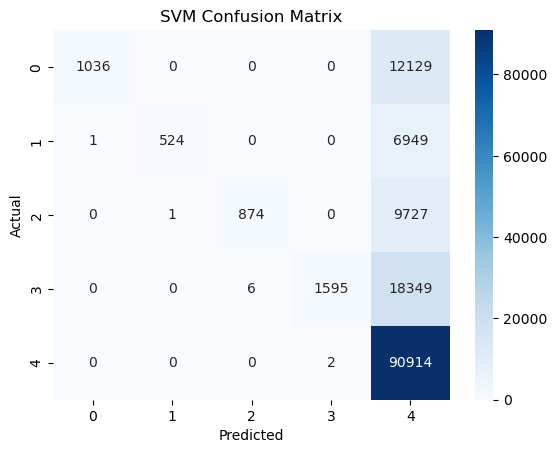

In [53]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Predict using the SVM model
svm_predictions = svm_classifier.predict(xvalid_tfidf)

# Generate the confusion matrix
svm_cm = confusion_matrix(valid_y, svm_predictions)

# Plot the confusion matrix using seaborn
sns.heatmap(svm_cm, annot=True, fmt='d', cmap='Blues')
plt.title('SVM Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


### Sentiment scores
 *Sentiment Analysis: Pretrained model takes the input from the text description and outputs the sentiment score ranging from -1 to +1 for each sentence*

In [54]:
#Read the data
df = pd.read_csv('Reviews.csv')

In [55]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from tqdm import tqdm

# Initialize the VADER sentiment analyzer
analyzer = SentimentIntensityAnalyzer()

# Function to get the sentiment scores
def get_sentiment_scores(text):
    return analyzer.polarity_scores(text)

# Apply the function to the 'Text' column with a progress bar
tqdm.pandas()
df['Sentiment_Scores'] = df['Text'].progress_apply(get_sentiment_scores)

# Extract the individual sentiment scores (compound, neg, neu, pos) from the dictionary
df['Compound'] = df['Sentiment_Scores'].apply(lambda x: x['compound'])
df['Neg'] = df['Sentiment_Scores'].apply(lambda x: x['neg'])
df['Neu'] = df['Sentiment_Scores'].apply(lambda x: x['neu'])
df['Pos'] = df['Sentiment_Scores'].apply(lambda x: x['pos'])

# Display the updated dataframe
df.head()


100%|████████████████████████████████████████████████████████████████████████| 568454/568454 [09:01<00:00, 1049.95it/s]


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment_Scores,Compound,Neg,Neu,Pos
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"{'neg': 0.0, 'neu': 0.711, 'pos': 0.289, 'comp...",0.9441,0.000,0.711,0.289
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"{'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'comp...",-0.5664,0.138,0.862,0.000
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"{'neg': 0.085, 'neu': 0.771, 'pos': 0.144, 'co...",0.8138,0.085,0.771,0.144
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,"{'neg': 0.0, 'neu': 0.932, 'pos': 0.068, 'comp...",0.4404,0.000,0.932,0.068
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,"{'neg': 0.0, 'neu': 0.599, 'pos': 0.401, 'comp...",0.9468,0.000,0.599,0.401


In [56]:
df[['Compound', 'Neg', 'Neu', 'Pos']]

,Compound,Neg,Neu,Pos
0,0.9441,0.000,0.711,0.289
1,-0.5664,0.138,0.862,0.000
2,0.8138,0.085,0.771,0.144
3,0.4404,0.000,0.932,0.068
4,0.9468,0.000,0.599,0.401
...,...,...,...,...
568449,0.8589,0.068,0.623,0.309
568450,-0.8780,0.241,0.717,0.042
568451,0.4352,0.037,0.886,0.077
568452,0.9717,0.041,0.506,0.452


In [57]:
# Merging the sentiments back to reviews dataframe
df_c = pd.concat([df.reset_index(drop=True)], axis=1)
df_c.head(3)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment_Scores,Compound,Neg,Neu,Pos
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"{'neg': 0.0, 'neu': 0.711, 'pos': 0.289, 'comp...",0.9441,0.000,0.711,0.289
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"{'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'comp...",-0.5664,0.138,0.862,0.000
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"{'neg': 0.085, 'neu': 0.771, 'pos': 0.144, 'co...",0.8138,0.085,0.771,0.144


In [58]:
df_c['Sentiment'] =  np.where(df_c['Compound'] >= 0 , 'Positive', 'Negative')
df_c.head(5)

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment_Scores,Compound,Neg,Neu,Pos,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"{'neg': 0.0, 'neu': 0.711, 'pos': 0.289, 'comp...",0.9441,0.000,0.711,0.289,Positive
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"{'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'comp...",-0.5664,0.138,0.862,0.000,Negative
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"{'neg': 0.085, 'neu': 0.771, 'pos': 0.144, 'co...",0.8138,0.085,0.771,0.144,Positive
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,"{'neg': 0.0, 'neu': 0.932, 'pos': 0.068, 'comp...",0.4404,0.000,0.932,0.068,Positive
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,"{'neg': 0.0, 'neu': 0.599, 'pos': 0.401, 'comp...",0.9468,0.000,0.599,0.401,Positive


### Business insights

*We just took a sample of all  reviews and completed sentiment 
analysis. If you look, more than 90% reviews are positive, which is really good for any business.*

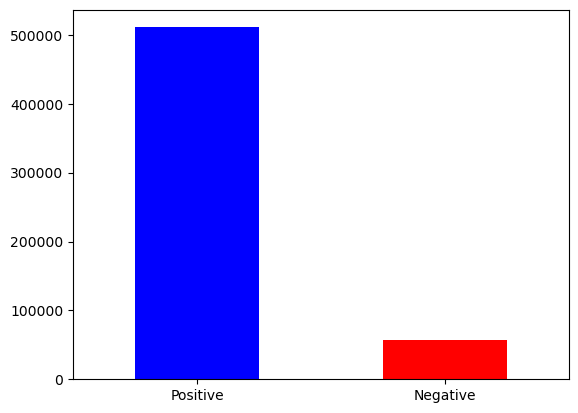

In [57]:
result=df_c['Sentiment'].value_counts()
result.plot(kind='bar', rot=0,color=['blue', 'red']);

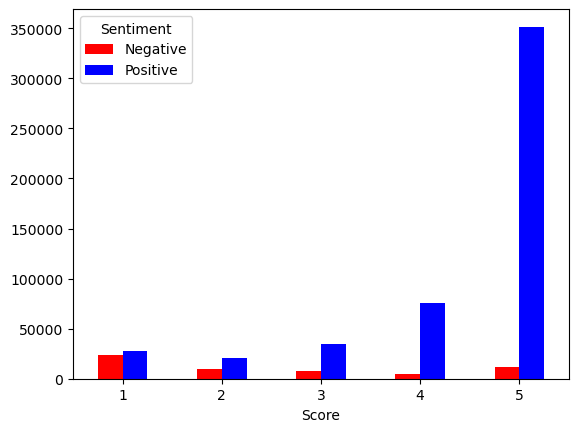

In [81]:
import matplotlib
import matplotlib.pyplot as plt

result = df_c.groupby(['Score', 'Sentiment']).size().unstack(fill_value=0).head(5)
result[['Negative', 'Positive']].plot(kind='bar', rot=0, color=['red', 'blue'])
plt.show()


In [63]:
import pandas as pd

# Remove rows with score = 3
df = df[df['Score'] != 3].copy()  # Create a copy to avoid SettingWithCopyWarning

# Assign sentiment based on the score
df.loc[:, 'Sentiment'] = df['Score'].apply(lambda rating: +1 if rating > 3 else -1)

# Display the updated DataFrame
df.head(4)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment_Scores,Compound,Neg,Neu,Pos,Sentiment
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"{'neg': 0.0, 'neu': 0.711, 'pos': 0.289, 'comp...",0.9441,0.000,0.711,0.289,1
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"{'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'comp...",-0.5664,0.138,0.862,0.000,-1
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"{'neg': 0.085, 'neu': 0.771, 'pos': 0.144, 'co...",0.8138,0.085,0.771,0.144,1
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,"{'neg': 0.0, 'neu': 0.932, 'pos': 0.068, 'comp...",0.4404,0.000,0.932,0.068,-1


In [65]:
from nltk.corpus import stopwords

# Define stopwords
STOPWORDS = set(stopwords.words('english'))

def remove_stopwords(text):
    """Custom function to remove stopwords."""
    return " ".join([word for word in str(text).split() if word.lower() not in STOPWORDS])

# Apply stopword removal using .loc
df.loc[:, 'text'] = df['Text'].apply(lambda text: remove_stopwords(text))

# Display the result
df.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,Sentiment_Scores,Compound,Neg,Neu,Pos,Sentiment,sentimentt,text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,5,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...,"{'neg': 0.0, 'neu': 0.711, 'pos': 0.289, 'comp...",0.9441,0.000,0.711,0.289,1,positive,bought several Vitality canned dog food produc...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,1,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...,"{'neg': 0.138, 'neu': 0.862, 'pos': 0.0, 'comp...",-0.5664,0.138,0.862,0.000,-1,negative,Product arrived labeled Jumbo Salted Peanuts.....
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,4,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...,"{'neg': 0.085, 'neu': 0.771, 'pos': 0.144, 'co...",0.8138,0.085,0.771,0.144,1,positive,"confection around centuries. light, pillowy ci..."
3,4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,2,1307923200,Cough Medicine,If you are looking for the secret ingredient i...,"{'neg': 0.0, 'neu': 0.932, 'pos': 0.068, 'comp...",0.4404,0.000,0.932,0.068,-1,negative,looking secret ingredient Robitussin believe f...
4,5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,5,1350777600,Great taffy,Great taffy at a great price. There was a wid...,"{'neg': 0.0, 'neu': 0.599, 'pos': 0.401, 'comp...",0.9468,0.000,0.599,0.401,1,positive,Great taffy great price. wide assortment yummy...


In [74]:
# Give reviews with score > 3 to be positive rating and reviews with a score < 3 as a negative
def polarity(x):
    if x < 3:
        return 'Negative'
    else:
        return 'Positive'
df["Score"] = df["Score"].map(polarity) # map is use to assign in all the Score

In [75]:
df = pd.DataFrame(df, columns=['Score', 'Summary','Text'])
print(df.shape)
df['Score'].astype('category').value_counts()

(525814, 3)


Positive    443777
Negative     82037
Name: Score, dtype: int64

In [76]:
import matplotlib.pyplot as plt
#Create a new data frame "reviews" to perform exploratory data analysis upon that
reviews =df
#Dropping null values
reviews.dropna(inplace=True)

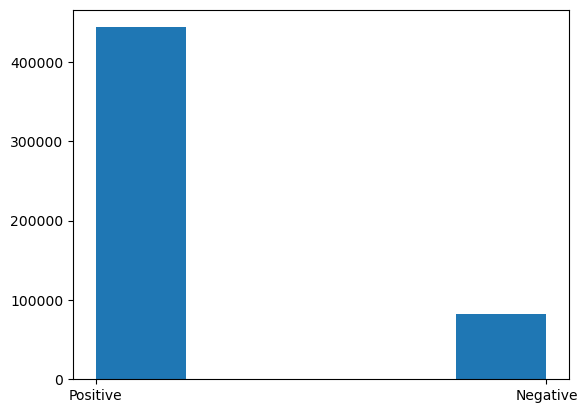

Score
Negative     82012
Positive    443777
Name: Text, dtype: int64


In [77]:
#The histogram reveals this dataset is highly unbalanced towards hih rating 
reviews.Score.hist(bins=5,grid=False)
plt.show()
print(reviews.groupby('Score').count().Text)